In [37]:
from sklearn.neighbors import KNeighborsRegressor
from other_models import gaussian_LIME_explainer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import torch
from other_models import ConvNN
from other_utils import split_dataset, get_images_ds, save_images, MAE, load_images, circle_uniform, draw_explanations_comparison_chart
from dual_model import dual_MSE_explainer
from dual_model_utils import run_dual_model, plot_shape_functions, plot_shape_functions_single_plot
import pandas as pd
device = torch.device('cpu')
np.random.seed(141516)

# Example of an feature-based explanataion (feature-based experiment №3 from article)

### Parameters

In [20]:
R = 2
r = 1.9
n = 100
N = 400
nu = 0.01
perturbed_samples_count = 30
dual_samples_cnt = 30
cov = np.eye(2) * 0.05
nbrs_num = 6
nbrs_num_knn_reg = 6

## Dataset visualization

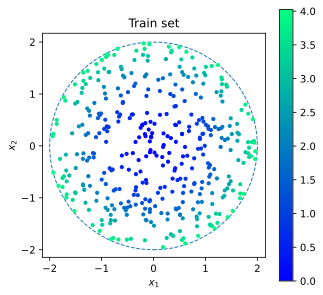

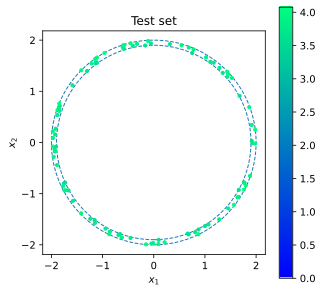

In [21]:
explainable_func = lambda x1, x2: x1 * x1 + x2 * x2 + np.random.normal(0, 0.05, x1.shape[0])
x_train, y_train = circle_uniform(0, R, N)
x_test, y_test = circle_uniform(r, R, n)
for dataset_type in ('Train set', 'Test set'):
        circle = plt.Circle((0, 0), R, fill=False, color='tab:blue', linestyle='--')
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_aspect(1)
        ax.add_artist(circle)
        if dataset_type == 'Train set':
            x, y = x_train, y_train
        else:
            x, y = x_test, y_test
            inner_circle = plt.Circle((0, 0), r, fill=False, color='tab:blue', linestyle='--')
            ax.add_artist(inner_circle)
        plt.scatter(x, y, c=explainable_func(x,y), s=10, cmap='winter', vmin=0)
        plt.colorbar()
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.title(dataset_type)
        #plt.savefig()
        plt.show()

## Experiment

In [22]:
explainable_func = lambda X: 2 * X[:, 0] * X[:, 0] + X[:, 1] * X[:, 1] + np.random.normal(0, 0.05, X.shape[0])
dta = np.array([x_train, y_train]).T
dta_test = np.array([x_test, y_test]).T
values = explainable_func(dta)
rf = RandomForestRegressor().fit(dta, values)
knn_reg = KNeighborsRegressor(n_neighbors=nbrs_num_knn_reg).fit(dta, values)
models = [knn_reg, rf]
models_MSE = []
values_test = explainable_func(dta_test)
nbrs = NearestNeighbors(n_neighbors=nbrs_num).fit(dta)

for model in models:
    f = lambda X: model.predict(X).flatten()
    circle_dual_explainer = dual_MSE_explainer(f)
    
    predictions_dual = []
    for test_point in dta_test:
        _, indices = nbrs.kneighbors(test_point.reshape(1, -1))
        points = np.append(dta[indices[0]], test_point.reshape(1, -1), axis=0)
        hull = ConvexHull(points)
        vertices = points[hull.vertices]
        circle_dual_explainer.set_extreme_points(vertices)
        coefs = circle_dual_explainer.explain(dual_samples_cnt)
        predictions_dual.append(np.dot(coefs, test_point))
        
    dual_mse = mean_squared_error(predictions_dual, values_test)
    
    
    circle_test_LIME_explainer = gaussian_LIME_explainer(f)
    
    base_predictions = []
    for test_point in dta_test:
        circle_test_LIME_explainer.make_perturbed_background(test_point, cov, perturbed_samples_count)
        coefs_base = circle_test_LIME_explainer.explain(test_point, nu=nu)
        base_predictions.append(np.dot(coefs_base, test_point))
    base_mse = mean_squared_error(base_predictions, values_test)
    models_MSE.append((base_mse, dual_mse))

## Results visualization

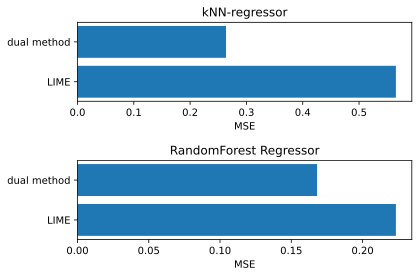

In [23]:
methods_labels = [r'LIME', 'dual method']
titles = ['kNN-regressor', 'RandomForest Regressor']
label = 'MSE'
draw_explanations_comparison_chart(methods_labels, models_MSE,
                                       label, titles, savefig_name='Exp3(FB).png',
                                       subplots_adjust_hspace=0.75)

# Example of an example-based explanataion (image experiment from article)

### Model loading

In [27]:
def train_image_regressor():
    batch_size = 128
    epochs = 200
    patience = 10
    tr_img, tr_lbl, val_img, val_lbl, test_img, test_lbl = split_dataset(*get_images_ds('./UTKFace/'))
    save_images('train_data', tr_img, tr_lbl)
    save_images('test_data', test_img, test_lbl)
    nn = ConvNN()
    opt = torch.optim.Adam(nn.parameters())
    loss = MAE
    nn.fit_proc(tr_img, tr_lbl, loss, opt, batch_size, epochs, (val_img, val_lbl), patience)
    print('test MAE:', np.mean(np.abs(test_lbl - nn.predict(test_img))))
    nn.save('nn_weights')

nn = ConvNN().to(device)
train_image_regressor() # before running this function
                        # make sure that script directory
                        # contains UTKFace dataset
                        # source: https://www.kaggle.com/datasets/jangedoo/utkface-new
nn.load('nn_weights')

### Data preprocessing

In [24]:
test_img, test_lbl = load_images('test_data_img', 'test_data_lbl')
train_img, train_lbl = load_images('train_data_img', 'train_data_lbl')
X_train = train_img[:,0,:,:].reshape(-1, 128 * 128)
X_test = test_img[:,0,:,:].reshape(-1, 128 * 128)

### Parameters

In [33]:
N = 10  #neighbours
n = 3000
ind = 1013  #indice of explained instance (from test data)
params_NAM = {'bias': True, 'learning_rate': 0.0005, 'a_1':0, 'a_2':0,
              'epochs': 100, 'batch_size': 128}
model_type = ['NAM']
model_params = [params_NAM]

### Explained instance 

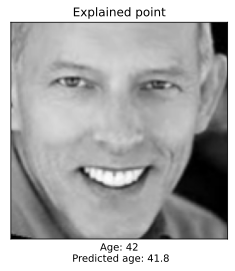

In [29]:
plt.imshow(X_test[ind].reshape(128,128), cmap='gray')
predicted_age = func(X_test[ind].reshape(1,-1))[0]
real_age = int(test_lbl[ind][0])
plt.xlabel(f'Age: {real_age}\n Predicted age: {predicted_age:.1f}')
plt.title('Explained point')
plt.grid(False)
plt.xticks([])
plt.yticks([])
#plt.savefig(destination_folder + 'Explained_point'+ '.png', dpi=220, bbox_inches='tight')
plt.show()

## Experiment

In [28]:
func = lambda x: nn.predict(x.reshape(-1, 128, 128)[:,np.newaxis,:,:]).reshape(-1,)
#metrics: 'l1', 'l2', 'cosine', 'WEuclDis1', 'WEuclDis2', 'WEuclDis3'
WEuclDis1 = lambda x, y: 0.5 * np.linalg.norm(x[:-1] - y[:-1]) + 0.5 * np.abs(x[-1] - y[-1])
WEuclDis2 = lambda x, y: 0.7 * np.linalg.norm(x[:-1] - y[:-1]) + 0.3 * np.abs(x[-1] - y[-1])
WEuclDis3 = lambda x, y: np.sqrt(0.25 * np.linalg.norm(x[:-1] - y[:-1]) ** 2 + 0.75 * (x[-1] - y[-1]) ** 2)

metric = 'cosine'

if metric in ('l1', 'l2', 'cosine'):
    nbrs = NearestNeighbors(n_neighbors=N, metric=metric).fit(X_train)
    _, indices = nbrs.kneighbors(X_test[ind].reshape(1,-1))
else:
    joined_X = np.hstack((X_train, train_lbl)) #making age a new component of image vector
    nbrs = NearestNeighbors(n_neighbors=N, metric=metric).fit(joined_X)
    _, indices = nbrs.kneighbors(np.hstack((X_test[ind].reshape(1,-1), func(X_test[ind].reshape(1,-1))[:,np.newaxis])))
    
lambdas_raw = np.random.dirichlet(np.ones(N + 1), 3000)
X_vertices = np.append(X_train[indices[0]], X_test[ind].reshape(1,-1),axis=0)
X_nam_train = lambdas_raw @ X_vertices
z = func(X_nam_train)
lambdas = lambdas_raw[:,:-1]

In [ ]:
importances, model = run_dual_model(lambdas, z, model_type[0], model_params[0])

## Results visualization 

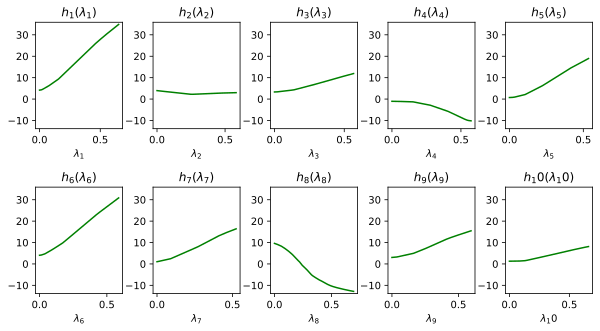

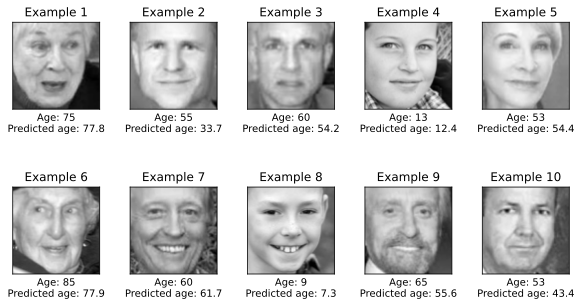

In [36]:
plot_shape_functions_single_plot(model, lambdas, plot_dimensions=(2, 5),
                             hspace=0.55, wspace=0.35, figsize=(10,5), horizontal_window=1)
k = 0
fig, ax = plt.subplots(2, 5, figsize=(10,5))
predicted_ages = func(X_train[indices[0]])
real_ages = train_lbl[indices[0]].ravel()
for i in range(2):
    for j in range(5):
        predicted_age = predicted_ages[k]
        real_age = real_ages[k]
        ax[i,j].imshow(X_train[indices[0]][k].reshape(128,128), cmap='gray')
        ax[i,j].set_xlabel(f'Age: {real_age:.0f}\nPredicted age: {predicted_age:.1f}')
        #ax[i,j].set_ylabel('$y$')
        #ax[i, j].set_ylim([min_z -1, max_z + 1])
        ax[i,j].set_title(f'Example {k+1}')
        ax[i,j].grid(False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.subplots_adjust(hspace=0.55, wspace=0.35)
#plt.savefig(destination_folder + 'examples_all'+ '.png', dpi=220, bbox_inches='tight')
plt.show()